# VGG16 for CIFAR10 test

In [1]:
'''
data: 2021/5/14
VGG13 for Cifar10
'''
import matplotlib.pyplot as plt
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from data_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [3]:
from classifiers.vgg import VGGNet 

weight_decay = 5e-4
lr = 1e-1
num_classes = 10

vgg = VGGNet(classes=num_classes, 
             input_shape=x_train.shape[1:], 
             weight_decay=weight_decay, 
             conv_block_num=4,
             fc_layers=2,
             fc_units=512
             ) 

# sgd
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
vgg.compile(loss='categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy'])
vgg.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
bn1-1 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-1 (Activation)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv1-2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
bn1-2 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-2 (Activation)         (None, 32, 32, 64)       

In [4]:
%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = True


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 50))

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 128
epochs = 200

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = vgg.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs,
                                callbacks=[reduce_lr],
                                validation_data=(x_val, y_val)
                                )
else:
    print('train without data augmentation')
    history = vgg.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[reduce_lr],
                      validation_data=(x_val, y_val)
                      )

train with data augmentation
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
313/313 [==============================] - 42s 134ms/step - loss: 5.4713 - accuracy: 0.1867 - val_loss: 4.4045 - val_accuracy: 0.1667
Epoch 2/200
313/313 [==============================] - 40s 127ms/step - loss: 3.4823 - accuracy: 0.3332 - val_loss: 3.0895 - val_accuracy: 0.2936
Epoch 3/200
313/313 [==============================] - 40s 126ms/step - loss: 2.5029 - accuracy: 0.4405 - val_loss: 2.3569 - val_accuracy: 0.4125
Epoch 4/200
313/313 [==============================] - 40s 128ms/step - loss: 1.9773 - accuracy: 0.5130 - val_loss: 1.9261 - val_accuracy: 0.5165
Epoch 5/200
313/313 [==============================] - 39s 125ms/step - loss: 1.6541 - accuracy: 0.5802 - val_loss: 1.8110 - val_accuracy: 0.5436
Epoch 6/200
313/313 [==============================] - 40s 128ms/step - loss: 1.4767 - accuracy: 0.6265 - val_loss: 1.4953 - val_accuracy: 0.6047
Epoch 7/200
313/313

Epoch 109/200
313/313 [==============================] - 42s 134ms/step - loss: 0.3012 - accuracy: 0.9890 - val_loss: 0.5558 - val_accuracy: 0.9250
Epoch 110/200
313/313 [==============================] - 41s 130ms/step - loss: 0.2961 - accuracy: 0.9909 - val_loss: 0.5720 - val_accuracy: 0.9216
Epoch 111/200
313/313 [==============================] - 40s 128ms/step - loss: 0.2929 - accuracy: 0.9913 - val_loss: 0.5660 - val_accuracy: 0.9251
Epoch 112/200
313/313 [==============================] - 40s 128ms/step - loss: 0.2899 - accuracy: 0.9915 - val_loss: 0.5658 - val_accuracy: 0.9250
Epoch 113/200
313/313 [==============================] - 40s 127ms/step - loss: 0.2883 - accuracy: 0.9919 - val_loss: 0.5681 - val_accuracy: 0.9240
Epoch 114/200
313/313 [==============================] - 71s 225ms/step - loss: 0.2865 - accuracy: 0.9919 - val_loss: 0.5663 - val_accuracy: 0.9248
Epoch 115/200
313/313 [==============================] - 42s 134ms/step - loss: 0.2827 - accuracy: 0.9930 - val_

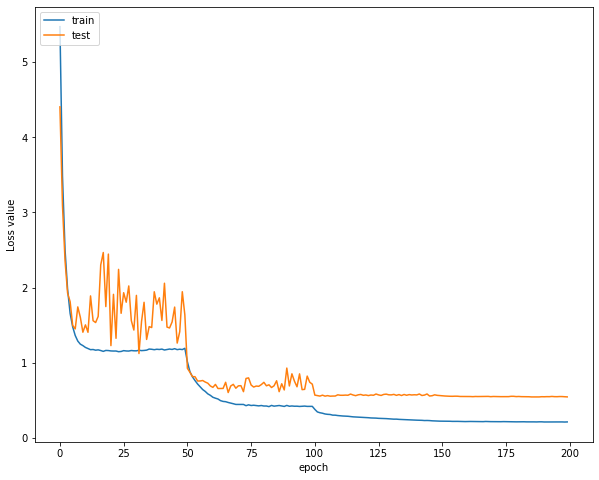

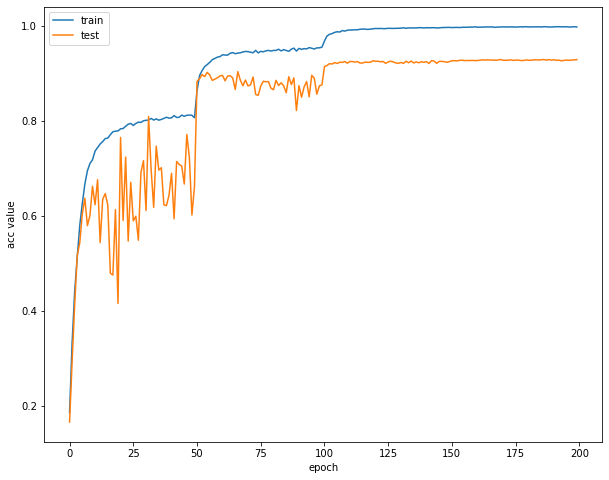

In [6]:
# plot loss and acc 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
loss, acc = vgg.evaluate(x_test, y_test)
print('evaluate loss:%f acc:%f' % (loss, acc))

313/313 [==============================] - 5s 15ms/step - loss: 0.5900 - accuracy: 0.9210
evaluate loss:0.590023 acc:0.921000


In [8]:
vgg.save('vgg16.h5')